In [1]:
from zipfile import ZipFile
from pathlib import Path
import napari
from napari.utils import nbscreenshot
import time
from shapely.geometry import GeometryCollection
from shapely.geometry import Point
from skimage.transform import AffineTransform
import dask.array as da
from dask.array.core import normalize_chunks
from scipy.ndimage import affine_transform
from functools import partial
# 
from utils.download_sample import download_from_dropbox
from utils.coordinate_utils import extract_coordinates, normalize_coords_to_pixel
from utils.imutils import *
from utils.shapely_and_napari_utils import *
from utils.chunks import get_chunk_coordinates, get_rect_from_chunk_slice, tile_chunk_intersections
from fuse.fuse import fuse_func

In [2]:
%gui qt

In [3]:
time.sleep(1)

In [4]:
if not Path("Stiching_Example_Dataset").exists():
    # Download and extract sample data
    example_dataset="https://www.dropbox.com/s/rhggl54sbpx9llj/Stiching_Example_Dataset.zip?dl=0"
    print("Downloading sample file from dropbox")
    download_from_dropbox(example_dataset, "_sample.zip")
    print("Extracting sample file")
    ZipFile("_sample.zip").extractall()

In [5]:
coords = extract_coordinates("Stiching_Example_Dataset/out.txt")
coords

,name,X,Y,Z,um/px
0,1_0000,3582.7,4164.4,1686.65,0.64
1,1_0001,-12396.6,11719.3,1686.63,0.64
2,1_0002,-13583.0,11726.0,1686.63,0.64
3,1_0003,-14769.3,11732.8,1686.63,0.64
4,1_0004,-15955.6,11739.5,1686.63,0.64
...,...,...,...,...,...
67,1_0067,-16003.1,3370.3,1686.63,0.64
68,1_0068,-14816.8,3363.5,1686.63,0.64
69,1_0069,-13630.5,3356.8,1686.63,0.64
70,1_0070,-12444.2,3350.1,1686.63,0.64


In [6]:
files = sorted(list(Path("Stiching_Example_Dataset").glob("*.jpg")))

In [7]:
normalized_coords=normalize_coords_to_pixel(coords).to_numpy()

In [8]:
v = napari.Viewer()

2021-06-25 09:47:28,743 [INFO] WRITING LOG OUTPUT TO /home/hilsenst/.cellpose/run.log


In [9]:
input_transforms = [crop_black_border, 
                    partial(select_channel, channel=0), 
                    transpose]
_load_image = partial(load_image, transforms=input_transforms)

In [10]:
tile_shape=_load_image(str(files[0])).shape
tile_shape

bboxes = []
transforms = []
# skip first image as it is an outlier (stage position wise)
for coord in normalized_coords[1:]:
    translate = AffineTransform(translation=coord)
    bboxes.append(
        get_transformed_bbox(tile_shape[:2], translate.params))
    transforms.append(translate.params)

In [11]:
mosaic = GeometryCollection([napari_shape_to_shapely(s) for s in bboxes])

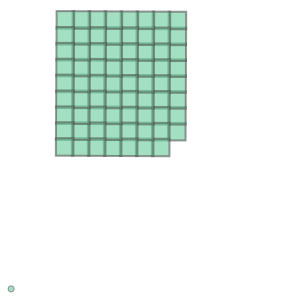

In [12]:
origin = Point(0,0)
GeometryCollection((origin, mosaic))

### Move to origin
Find the translation that moves the stitched area to the origin and determine the size of the Zarr array we require.

In [13]:
all_bboxes = np.vstack(bboxes)

In [14]:
# minimum extents
all_min = all_bboxes.min(axis=0)
all_min

array([-32419.375  ,   5223.90625])

In [15]:
# maximum extents
all_max = all_bboxes.max(axis=0)
all_max

array([-15482.71875,  20433.15625])

In [16]:
# total extents shape
all_max - all_min

array([16936.65625, 15209.25   ])

In [17]:
stitched_shape=tuple(np.ceil(all_max-all_min).astype(np.int))
stitched_shape

(16937, 15210)

In [18]:
shift_to_origin = AffineTransform(translation=-all_min)
shift_to_origin.params

array([[ 1.00000000e+00, -0.00000000e+00,  3.24193750e+04],
       [ 0.00000000e+00,  1.00000000e+00, -5.22390625e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [19]:
# shift all layers of mosaic
transforms = [t @ shift_to_origin.params for t in transforms ]

In [20]:
shifted_bboxes = []
for t, coord in zip(transforms,
                    normalized_coords[1:]):
    shifted_bboxes.append(
        get_transformed_bbox(tile_shape[:2], t))
shifted_bboxes

[array([[13049.6875, 13087.5   ],
        [15093.6875, 13087.5   ],
        [15093.6875, 15135.5   ],
        [13049.6875, 15135.5   ]]),
 array([[11195.9375 , 13097.96875],
        [13239.9375 , 13097.96875],
        [13239.9375 , 15145.96875],
        [11195.9375 , 15145.96875]]),
 array([[ 9342.34375, 13108.59375],
        [11386.34375, 13108.59375],
        [11386.34375, 15156.59375],
        [ 9342.34375, 15156.59375]]),
 array([[ 7488.75  , 13119.0625],
        [ 9532.75  , 13119.0625],
        [ 9532.75  , 15167.0625],
        [ 7488.75  , 15167.0625]]),
 array([[ 5635.15625, 13129.6875 ],
        [ 7679.15625, 13129.6875 ],
        [ 7679.15625, 15177.6875 ],
        [ 5635.15625, 15177.6875 ]]),
 array([[ 3781.5625 , 13140.15625],
        [ 5825.5625 , 13140.15625],
        [ 5825.5625 , 15188.15625],
        [ 3781.5625 , 15188.15625]]),
 array([[ 1927.96875, 13150.625  ],
        [ 3971.96875, 13150.625  ],
        [ 3971.96875, 15198.625  ],
        [ 1927.96875, 15198.625 

In [21]:
mosaic_shifted = GeometryCollection([napari_shape_to_shapely(s) for s in shifted_bboxes])

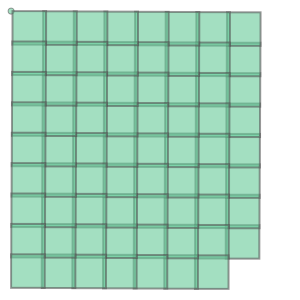

In [22]:

origin = Point(0,0)
GeometryCollection((origin, mosaic_shifted))

## Create a dask array

In [23]:
chunk_size = (4096,4096)

In [24]:
#input_dtype = mosaic_layers[0].data.dtype
#target_array = da.zeros(stitched_shape, dtype=input_dtype, chunks=(4000, 4000))
#target_array.chunks
chunks = normalize_chunks((4096,4096),shape=tuple(stitched_shape))
chunks

((4096, 4096, 4096, 4096, 553), (4096, 4096, 4096, 2922))

In [25]:
# sanity check
computed_shape = np.array(list(map(sum, chunks)))
assert np.all(np.array(stitched_shape) == computed_shape)

In [26]:
chunk_slices = list(get_chunk_coordinates(stitched_shape, chunk_size))
chunk_slices

[((0, 4096), (0, 4096)),
 ((0, 4096), (4096, 8192)),
 ((0, 4096), (8192, 12288)),
 ((0, 4096), (12288, 15210)),
 ((4096, 8192), (0, 4096)),
 ((4096, 8192), (4096, 8192)),
 ((4096, 8192), (8192, 12288)),
 ((4096, 8192), (12288, 15210)),
 ((8192, 12288), (0, 4096)),
 ((8192, 12288), (4096, 8192)),
 ((8192, 12288), (8192, 12288)),
 ((8192, 12288), (12288, 15210)),
 ((12288, 16384), (0, 4096)),
 ((12288, 16384), (4096, 8192)),
 ((12288, 16384), (8192, 12288)),
 ((12288, 16384), (12288, 15210)),
 ((16384, 16937), (0, 4096)),
 ((16384, 16937), (4096, 8192)),
 ((16384, 16937), (8192, 12288)),
 ((16384, 16937), (12288, 15210))]

In [27]:
chunk_shapes = list(map(get_rect_from_chunk_slice, chunk_slices))

In [28]:
chunks_shapely = GeometryCollection([napari_shape_to_shapely(c) for c in chunk_shapes])

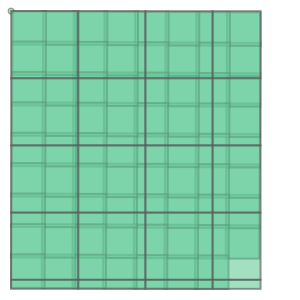

In [29]:
GeometryCollection([origin, mosaic_shifted, chunks_shapely])

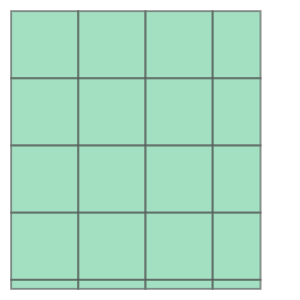

In [30]:
chunks_shapely

In [31]:
chunk_tiles = tile_chunk_intersections(mosaic_shifted, files[1:], transforms, chunks_shapely, chunk_slices)

In [32]:
chunk_tiles

{(0,
  0): [(PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0045.jpg'),
   array([[1.000000e+00, 0.000000e+00, 2.125000e+01],
          [0.000000e+00, 1.000000e+00, 3.820625e+03],
          [0.000000e+00, 0.000000e+00, 1.000000e+00]])), (PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0046.jpg'),
   array([[1.00000000e+00, 0.00000000e+00, 1.87484375e+03],
          [0.00000000e+00, 1.00000000e+00, 3.81000000e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), (PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0047.jpg'),
   array([[1.00000000e+00, 0.00000000e+00, 3.72843750e+03],
          [0.00000000e+00, 1.00000000e+00, 3.79953125e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), (PosixPath('Stiching_Example_Dataset/Well1_Seq0001_1_0060.jpg'),
   array([[1.00000000e+00, 0.00000000e+00, 3.71781250e+03],
          [0.00000000e+00, 1.00000000e+00, 1.93140625e+03],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), (PosixPath('St

In [33]:
_fuse_func=partial(fuse_func, 
                   imload_func=_load_image,
                   dtype=np.uint8)

In [34]:
target_array = da.map_blocks(func=_fuse_func,
                             chunks=normalize_chunks(chunk_size, stitched_shape), 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint8)

In [35]:
target_array.to_zarr("fused.zarr", overwrite=True)

Processing chunk at (0, 0)
Processing chunk at (0, 4096)
Processing chunk at (0, 8192)Processing chunk at (0, 12288)Processing chunk at (4096, 0)

Processing chunk at (4096, 4096)
Processing chunk at (4096, 8192)
Processing chunk at (4096, 12288)
Processing chunk at (8192, 0)

Processing chunk at (8192, 4096)Processing chunk at (8192, 8192)

Processing chunk at (8192, 12288)
Processing chunk at (12288, 0)
Processing chunk at (12288, 4096)
Processing chunk at (12288, 8192)
Processing chunk at (12288, 12288)
Processing chunk at (16384, 0)
Processing chunk at (16384, 4096)
Processing chunk at (16384, 8192)
Processing chunk at (16384, 12288)


In [36]:
v.add_image(da.from_zarr("fused.zarr"), name="Fused")

<Image layer 'Fused' at 0x7f3a5634d550>

In [37]:
_load_image(files[0]).shape

(2044, 2048, 1)